**BERT Model (No Preprocessing)**

credits: https://www.kaggle.com/code/siddharth2000/simple-bert-sarcasm-detection/notebook

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

import os
os.chdir("/content/gdrive/My Drive/kaggle")

Mounted at /content/gdrive


In [ ]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 7.4 MB/s 
     |████████████████████████████████| 1.6 MB 9.5 MB/s 


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 18.5 MB/s 
     |████████████████████████████████| 182 kB 64.7 MB/s 
     |████████████████████████████████| 7.6 MB 54.0 MB/s 


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet


import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
import torch
import transformers

# dir ="./Data/"
# file_path = "train-balanced-sarcasm.csv"
df = pd.read_csv("train-balanced-sarcasm.csv")
df.dropna(subset=['comment'], inplace=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Preprocessing used to test other hypotheses.
!pip install contractions
import contractions

def preprocessing_text(text):
  text = contractions.fix(text)
  to_tokenize = '!"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n.,:;!?'
  processed_text = re.sub(r'(['+to_tokenize+'])', r' \1 ', text)
  return processed_text

In [ ]:
def get_corpus(text):
  words = []
  for i in text:
    for j in i.split():
      words.append(j.strip())
  return words
corpus = get_corpus(df.comment)
corpus[:10]

['NC', 'and', 'NH.', 'You', 'do', 'know', 'west', 'teams', 'play', 'against']

In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'the': 367615,
 'a': 236417,
 'to': 233411,
 'I': 166302,
 'and': 159431,
 'of': 146014,
 'is': 143851,
 'you': 133152,
 'that': 120327,
 'in': 109853}

In [ ]:
df_X = df['comment'].copy() # get columns that are not 'label'
df_y = df['label'].copy() # get the column named 'label'; this is our label

df_X.head()

0                                           NC and NH.
1    You do know west teams play against west teams...
2    They were underdogs earlier today, but since G...
3    This meme isn't funny none of the "new york ni...
4                      I could use one of those tools.
Name: comment, dtype: object

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

In [ ]:
from tokenizers import BertWordPieceTokenizer
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-cased' , lower = False)
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Tokenizer(vocabulary_size=28996, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=400):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [ ]:
maxlen = 32

In [ ]:
x_train = fast_encode(X_train.values, fast_tokenizer, maxlen=maxlen)
x_test = fast_encode(X_test.values, fast_tokenizer, maxlen=maxlen)

In [ ]:
def build_model(transformer, max_len=400):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
bert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-cased')

Downloading:   0%|          | 0.00/354M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
model = build_model(bert_model, max_len=maxlen)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 32)]             0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  65190912 
 tilBertModel)               idden_state=(None, 32, 7            
                             68),                                
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                                 
 dense (Dense)               (None, 1)                 769       
                                                             

In [ ]:
history = model.fit(x_train,y_train,batch_size = 32, validation_data=(x_test,y_test),epochs = 3, verbose=1)
model.save("bert_sarcasm_cased_no_preprocessing_final")

Epoch 1/3
25270/25270 [==============================] - 3329s 131ms/step - loss: 0.5127 - accuracy: 0.7435 - val_loss: 0.4926 - val_accuracy: 0.7591
Epoch 2/3
25270/25270 [==============================] - 3322s 131ms/step - loss: 0.4531 - accuracy: 0.7846 - val_loss: 0.4822 - val_accuracy: 0.7655
Epoch 3/3
25270/25270 [==============================] - 3325s 132ms/step - loss: 0.3959 - accuracy: 0.8196 - val_loss: 0.5094 - val_accuracy: 0.7603


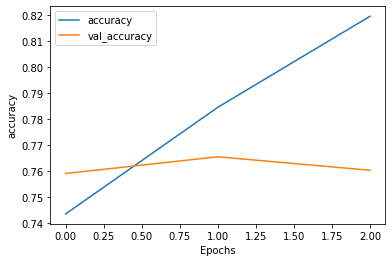

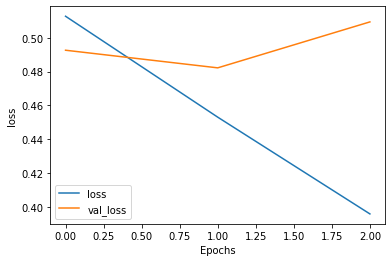

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
pred = model.predict(x_test)
print(y_test[:5])
pred[:5]

6318/6318 [==============================] - 258s 40ms/step
665355    1
773140    0
507645    1
646008    0
661080    1
Name: label, dtype: int64


array([[0.98857576],
       [0.7180571 ],
       [0.5646841 ],
       [0.4156143 ],
       [0.9711022 ]], dtype=float32)

In [ ]:
pred = np.round(pred).astype(int)
pred[:5]

array([[1],
       [1],
       [1],
       [0],
       [1]])

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76    100894
           1       0.76      0.77      0.76    101261

    accuracy                           0.76    202155
   macro avg       0.76      0.76      0.76    202155
weighted avg       0.76      0.76      0.76    202155



In [ ]:
cm = confusion_matrix(y_test,pred)
cm

array([[75692, 25202],
       [23246, 78015]])

Text(69.0, 0.5, 'Actual')

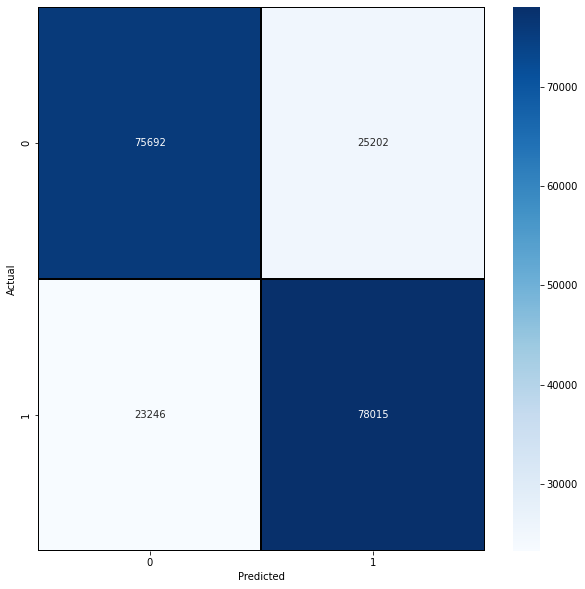

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
print(type(X_train.values))
print(type(X_train))
print(X_train.shape)

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
(808618,)


**Metrics**

In [ ]:
model = tf.saved_model.load("bert_sarcasm_cased_no_preprocessing_final")
# model = tf.keras.models.load_model("bert_sarcasm_cased_no_preprocessing_final")

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score

# can handle around 9000 x_test at once, more will result in ResourceExhaustedError
x_test_split = [x_test[i:i+5000] for i in range(0, len(x_test), 5000)]
pred = []

for i in x_test_split:
  i = tf.constant(i, dtype=tf.int32)
  predicted_subset = list(model.signatures["serving_default"](i).values())[0].numpy()
  predicted_subset = np.round(predicted_subset).astype(int)
  pred.append(predicted_subset.tolist())

# flatten list of lists
pred = [i for sublist in pred for i in sublist]

# credits to https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/
accuracy = accuracy_score(y_test, pred)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, pred)
print('Precision: %f' % precision)

recall = recall_score(y_test, pred)
print('Recall: %f' % recall)

f1 = f1_score(y_test, pred)
print('F1 score: %f' % f1)

auc = roc_auc_score(y_test, pred)
print('ROC AUC: %f' % auc)

matrix = confusion_matrix(y_test, pred)
print(matrix)

Accuracy: 0.760342
Precision: 0.755835
Recall: 0.770435
F1 score: 0.763065
ROC AUC: 0.760324
[[75692 25202]
 [23246 78015]]


**Explaining local instances with LIME**

In [ ]:
!pip install lime
from lime.lime_text import LimeTextExplainer

class_names=['not sarcastic','sarcastic']
explainer= LimeTextExplainer(class_names=class_names)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 33.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=af315199925ffffef78faa6699a627628202a72245f351cedb2daac6df9df012
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
def predictTextArray(texts):
  # processed_texts = [preprocessing_text(i) for i in texts]
  processed_texts_np = np.array(texts)
  tokenized_texts = fast_encode(processed_texts_np, fast_tokenizer, maxlen=maxlen)

  # https://stackoverflow.com/questions/58755970/how-to-load-a-model-with-tf-saved-model-and-call-the-predict-function-tensorflo
  tokenized_texts = tf.constant(tokenized_texts, dtype=tf.int32)
  pred = list(model.signatures["serving_default"](tokenized_texts).values())[0].numpy()
  
  # Explainable AI (using LIME)
  # https://jovian.ai/rajbsangani/lime-medium
  returnable=[]
  for i in pred:
    temp=i[0]
    returnable.append(np.array([1-temp,temp])) #I would recommend rounding temp and 1-temp off to 2 places

  return np.array(returnable)


def compare_pred_labels(pred, texts, labels, show_in_notebook=False):
  assert len(pred) == len(labels) and len(labels) == len(texts)

  pred = [i[1] for i in pred]
  pred = np.round(pred).astype(int)
  for i in range(len(pred)):
    output = texts[i]
    output += " | Expected: " + str(labels[i])
    output += " | Actual: " + str(pred[i])
    print(output)
    if show_in_notebook:
      explainer.explain_instance(texts[i], predictTextArray).show_in_notebook(text=True)
    else:
      explainer.explain_instance(texts[i], predictTextArray).as_pyplot_figure()
    print()
 

**LIME on Embedded Sarcasm**

If had a dollar for every smart thing you say. I’ll be poor. | Expected: 1 | Actual: 1

Since you’ve already made so many scintillating points this evening, I think you should let someone else voice their opinion. | Expected: 1 | Actual: 1

Because he’s been such a fine friend, I’ve struck him off my list. | Expected: 1 | Actual: 1



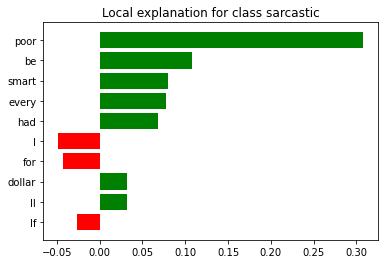

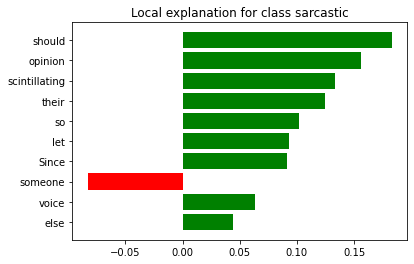

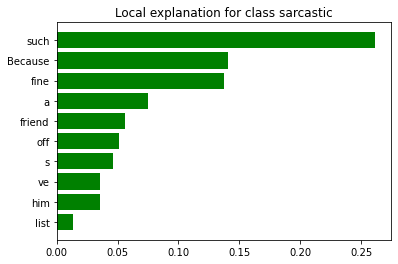

In [ ]:
# test with 3 types of sarcasm (credits to https://www.sas.upenn.edu/~campe/Papers/Camp.Sarcasm.pdf for the types of sarcasm and the examples under each type)
# 1. Embedded
sarcastic_comments = [
    "If had a dollar for every smart thing you say. I’ll be poor.", # credits to https://parade.com/1079501/stephanieosmanski/sarcastic-quotes/
    "Since you’ve already made so many scintillating points this evening, I think you should let someone else voice their opinion.",
    "Because he’s been such a fine friend, I’ve struck him off my list."
]

labels = [1 for i in sarcastic_comments]

predicted_labels = predictTextArray(sarcastic_comments)
# predicted_labels
compare_pred_labels(predicted_labels, sarcastic_comments, labels)

**LIME on Like-Prefixed Sarcasm**

Like that’s a good idea. | Expected: 1 | Actual: 1

She was like, you are so totally embarrassing me right now | Expected: 1 | Actual: 1

Like you care | Expected: 1 | Actual: 1



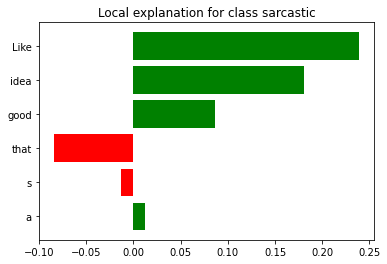

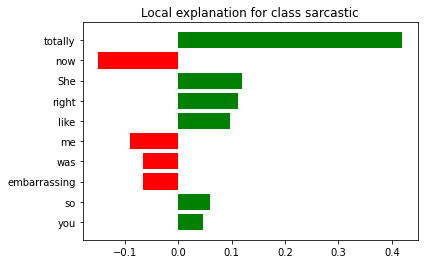

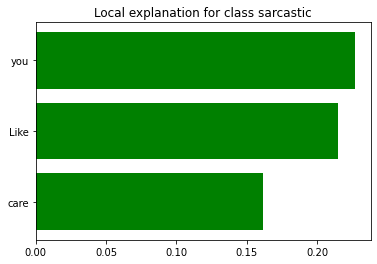

In [ ]:
# test with 3 types of sarcasm
# 2. Like-Prefixed
sarcastic_comments = [
    "Like that’s a good idea.",
    "She was like, you are so totally embarrassing me right now",
    "Like you care"
]

labels = [1 for i in sarcastic_comments]

predicted_labels = predictTextArray(sarcastic_comments)
# predicted_labels
compare_pred_labels(predicted_labels, sarcastic_comments, labels)

**LIME on Propositional Sarcasm**

To whom it may concern: John’s handwriting is excellent and his attendance at departmental events is punctual. | Expected: 1 | Actual: 0

This looks like a perfect plan! | Expected: 1 | Actual: 0

Your plan sounds fantastic. | Expected: 1 | Actual: 1



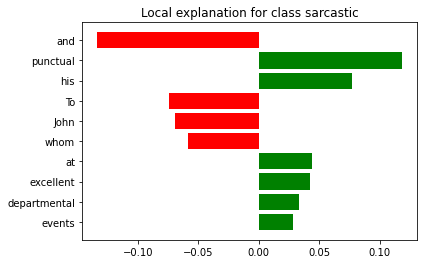

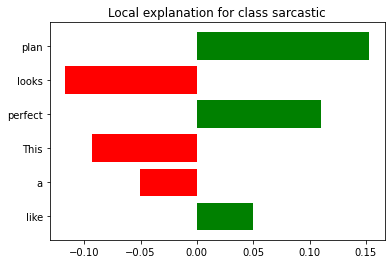

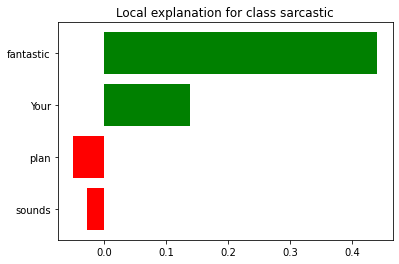

In [ ]:
# test with 3 types of sarcasm
# 1. Propositional
sarcastic_comments = [
    "To whom it may concern: John’s handwriting is excellent and his attendance at departmental events is punctual.",
    "This looks like a perfect plan!",
    "Your plan sounds fantastic."
]

labels = [1 for i in sarcastic_comments]

predicted_labels = predictTextArray(sarcastic_comments)
# predicted_labels
compare_pred_labels(predicted_labels, sarcastic_comments, labels)